# k-means Clustering

## Libraries and settings

In [19]:
# Install opencv-python-headless (neccessary in GitHub Codespaces)
!pip install --upgrade pip
!pip install opencv-python-headless

# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('\nCurrent working directory:', os.getcwd())

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable

Current working directory: /workspaces/DA_Project/Project/Additional/5


## 4.) Finding clusters in the apartment data
<a id='section_4'></a>

### Import the bmw data

In [20]:
# Read data to pandas data frame
df_orig = pd.read_csv('bmw_data_prepared.csv', 
                      sep=',', 
                      encoding='utf-8')

# Copy of data with selected colums
columns = [ 'web-scraper-order', 
                    'model_raw',
                    'Location',
                    'PLZ',
                    'Year',
                    'price',
                    'km',
                    'luxury',
                    'competition',
                    'xDrive',
                    'automat',
                    'km_cat',
                    'km_per_year',
                    'km_per_year_cat']
df = df_orig[columns]

# Rename variable 'web-scraper-order' to 'bmw_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'bmw_id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 2000) & 
            (df['price'] <= 200000)]

print(df.shape)
df.head(5)

(865, 19)


,bmw_id,web-scraper-start-url,text_raw,price_raw,model_raw,type_year_km_transmission_fuel,Location,PLZ,km_raw,Year,price,km,luxury,competition,xDrive,automat,km_cat,km_per_year,km_per_year_cat
0,1705078003-1,https://www.comparis.ch/carfinder/marktplatz/b...,BMW X3 X3 XDRIVE 20D XLINE STEPTRONICCHF 22'90...,CHF 22'900,X3 xDrive 20d xLine Steptronic,Occasion05.2016119.500 kmAutomatDiesel1227 (GE),GE,1227,119.50,2016,22900,119500.0,0,0,1,1,50-120k,14937.50,medium
1,1705078003-2,https://www.comparis.ch/carfinder/marktplatz/b...,BMW 540 540ICHF 13'750AB CHF 220 / MONAT5 / 6O...,CHF 13'750,540i,Occasion05.2006124.900 kmAutomatBenzin4461 (BL),BL,4461,124.90,2006,13750,124900.0,0,0,0,1,120k+,6938.89,low
2,1705078003-3,https://www.comparis.ch/carfinder/marktplatz/b...,BMW 225 ACTIVE TOURER 225XE IPERFORMANCE ACTIV...,CHF 28'800,225xe iPerformance Active Tourer Steptronic M ...,Occasion09.201928.950 kmAutomatBenzin/Elektro4...,BL,4460,28.95,2019,28800,28950.0,0,0,0,1,0-50k,5790.00,low
4,1705078003-5,https://www.comparis.ch/carfinder/marktplatz/b...,BMW 530 530XI STEPTRONICCHF 10'900AB CHF 175 /...,CHF 10'900,530xi Steptronic,Occasion06.2008160.000 kmAutomatBenzin6010 (LU),LU,6010,160.00,2008,10900,160000.0,0,0,0,1,120k+,10000.00,low
5,1705078003-6,https://www.comparis.ch/carfinder/marktplatz/b...,BMW X5 X5 XDRIVE 40D STEPTRONICCHF 33'900AB CH...,CHF 33'900,X5 xDrive 40d Steptronic,Occasion04.2015125.900 kmAutomatDiesel6964 (TI),TI,6964,125.90,2015,33900,125900.0,0,0,1,1,120k+,13988.89,medium


### Subset of the apartment data frame for k-means clustering

In [21]:
# Define a subset of the data frame for k-means clustering
X3 = df[['price',
         'km',
         'km_per_year']]

### Elbow method showing the optimal k

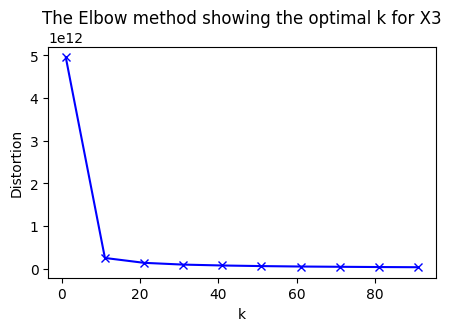

In [22]:
# Convert the data frame to a NumPy array
X3_array = X3.values

# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1, 100,10)

# Loop to find the optimal k
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X3_array)
    distortions.append(kmeans_model.inertia_)

# Elbow plot
plt.figure(figsize=(5, 3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k for X3')
plt.show()

### Perform k-means clustering on the bmw data

In [23]:
# Replace 'optimal_k' with the optimal number of clusters obtained from the elbow method
optimal_k = 5  # Change this to the actual optimal number of clusters

# Create and fit the k-means model
kmeans_bmw = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_bmw.fit(X3_array)

# Add the cluster labels to the original DataFrame 'X3'
X3['cluster'] = kmeans_bmw.labels_

# Display the first few rows of the DataFrame with cluster labels
print(X3.head())

   price        km  km_per_year  cluster
0  22900  119500.0     14937.50        0
1  13750  124900.0      6938.89        0
2  28800   28950.0      5790.00        1
4  10900  160000.0     10000.00        2
5  33900  125900.0     13988.89        0


In [24]:
# Number of clusters
k = 12

# Perform k-means clustering
kmeans_bmw = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_bmw.predict(X3)

# Show number of BMW per cluster
X3['cluster'].value_counts().sort_values(ascending=False)

cluster
6     120
11    114
7     105
1      87
2      77
8      75
5      71
4      67
0      59
3      50
10     26
9      14
Name: count, dtype: int64

In [25]:
# Print the cluster labels
print("Cluster Labels:")
print(kmeans_bmw.labels_, '\n')

# Print the inertia (sum of squared distances of samples to their closest cluster center)
print("Inertia:")
print(kmeans_bmw.inertia_, '\n')

# Print the cluster centers
print("Cluster Centers:")
print(kmeans_bmw.cluster_centers_, '\n')

Cluster Labels:
[ 6  6  2  1  6  9 11  6  6  8 11  4  6  0  1  0 11  2  8  5  7  2  4  4
  5  6  1  7  8  7  6  1  2 11  6 11  1  5  5 11  0  0  6 11  3  3 11  9
  5  4  6  3 11  1  3  7  0 11  3  5  3  6  6  1  5  6  6  5  5  6  6  6
  5  3  2 11  6  8  8  3  9  5  8  7  4  4 11  9  3  9  6  5  4  1  6  6
  8  2  0  6  8 11  0  8 11  2  4  7  2  7  1 11  4  1  0  5  1  1  2  8
  4  1  3  1  5  7  6  6 10  7  1  5 11  2  6  7 11 11  0  7  0 11 11  1
  5  1  1 11 10 10  4  2  2  7  7  5 11  1  6  6  6  6  4  1  6  2  1  3
  4  6  6  2  3 10  2 11  7  6 11  5 11  4  7  1 11  8  2  6  4  5  6 11
  4  5 11  7  0  2  5  6  6  6 10 11  2 11  1  7  4  0 10  4  6  1  3  6
  0  4  1  2  8 11 11  6  1  3  8  1  0 11 11  5  6  7  3  5  4  7  5  1
  8  7  4 11  4  8  8  7 11  2 11  0  8  0  3  7  2 10  2  2  8  4  0  8
  2 11 11  7  7  6 11  3  2  2  7  5  5  6  0  0 11  8  8  7 11  6  5  3
  1  6 11  7  0  0 11  8  5  1  1  2  5  7  2  7  2 10  2 11  8  2  2  7
  5  3  6  5  0 11  5  6  6  1  8  

### Plot the bmw clusters

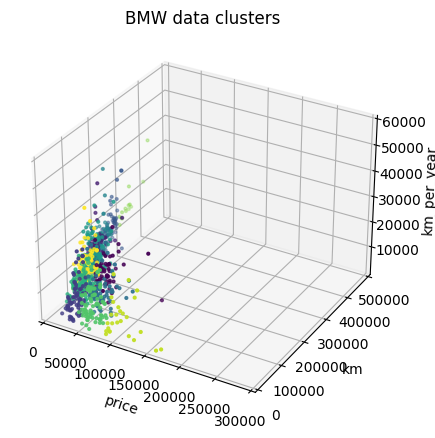

In [26]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['price'], df['km'], df['km_per_year'], c=kmeans_bmw.labels_, s=4)

# Set title and axes labels
ax.set_title('BMW data clusters', fontsize=12)
ax.set_xlabel('price', fontsize=10)
ax.set_ylabel('km', fontsize=10)
ax.set_zlabel('km_per_year', fontsize=10)

# Set axes range
ax.set_xlim([0,300000])
ax.set_ylim([0,500000])
ax.set_zlim([20,60000])

plt.show()

### Calculate the Silhouette Score

In [27]:
print(f'Silhouette Score: {silhouette_score(X3, kmeans_bmw.labels_):.4f}')

Silhouette Score: 0.3608


### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [28]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1018-azure
Datetime: 2024-01-13 12:28:58
Python Version: 3.10.13
-----------------------------------
